In [2]:
install.packages("pacman", repos = "http://cran.us.r-project.org")
pacman::p_load(pacman,tidyverse, dplyr, 
               ggplot2, glmnet, data.table)


The downloaded binary packages are in
	/var/folders/s_/d5qfzls10sz1z696lmcpvtfw0000gn/T//Rtmpcarry3/downloaded_packages


also installing the dependencies ‘iterators’, ‘foreach’




The downloaded binary packages are in
	/var/folders/s_/d5qfzls10sz1z696lmcpvtfw0000gn/T//Rtmpcarry3/downloaded_packages



glmnet installed


In [3]:
require(data.table)
require(glmnet)
require(ggplot2)
set.seed(123)
###reading data
housingData=fread('kc_house_data.csv')

##Removing non numeric var
housingData[,floors:=as.numeric(floors)][,c('zipcode','lat','long','id','date','sqft_basement'):=NULL]
 
###Splitting data
indexTrain=sample.int(nrow(housingData),nrow(housingData)*0.75)
 
 


In [4]:
##no Reg
lmNoReg=lm(price~.,housingData[indexTrain])
summary(lmNoReg)
pred_no_reg=predict(lmNoReg,housingData[-indexTrain])
 
sqrt(mean((pred_no_reg-housingData[-indexTrain]$price)^2))
 
 
plotCoeffEvolution=function(penalizedGlm,type='L1')
{
 require(ggplot2)
 lambda=penalizedGlm$lambda
 coeff=as.matrix(penalizedGlm$beta)
 rowName=rownames(coeff)
 coeff=data.table(coeff)
 coeff[,name:=rowName]
 coeff=melt(coeff,id.vars = 'name')
 coeff[,variable:=rep(lambda,each=length(unique(name)))]
 ggplot(coeff,aes(x=variable,y=value,color=name))+geom_line()+xlab(paste0(type,' regularisation'))+ylab('Value of coefficient')+scale_x_log10()+theme(legend.position="top")+geom_vline(xintercept=3000.95)
}
 




Call:
lm(formula = price ~ ., data = housingData[indexTrain])

Residuals:
     Min       1Q   Median       3Q      Max 
-1279695  -110392    -9815    90351  4208139 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.112e+06  1.634e+05  37.398  < 2e-16 ***
bedrooms      -4.150e+04  2.362e+03 -17.566  < 2e-16 ***
bathrooms      4.668e+04  4.104e+03  11.373  < 2e-16 ***
sqft_living    1.741e+02  5.503e+00  31.640  < 2e-16 ***
sqft_lot      -3.080e-02  6.138e-02  -0.502   0.6158    
floors         2.230e+04  4.448e+03   5.013 5.43e-07 ***
waterfront     5.529e+05  2.149e+04  25.735  < 2e-16 ***
view           4.454e+04  2.656e+03  16.774  < 2e-16 ***
condition      1.857e+04  2.944e+03   6.310 2.87e-10 ***
grade          1.165e+05  2.648e+03  43.986  < 2e-16 ***
sqft_above    -6.183e-01  5.364e+00  -0.115   0.9082    
yr_built      -3.516e+03  8.384e+01 -41.936  < 2e-16 ***
yr_renovated   1.109e+01  4.566e+00   2.429   0.0151 *  
sqft_living15  2.140

[1] 204758.7

Loading required package: plotly
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘plotly’”

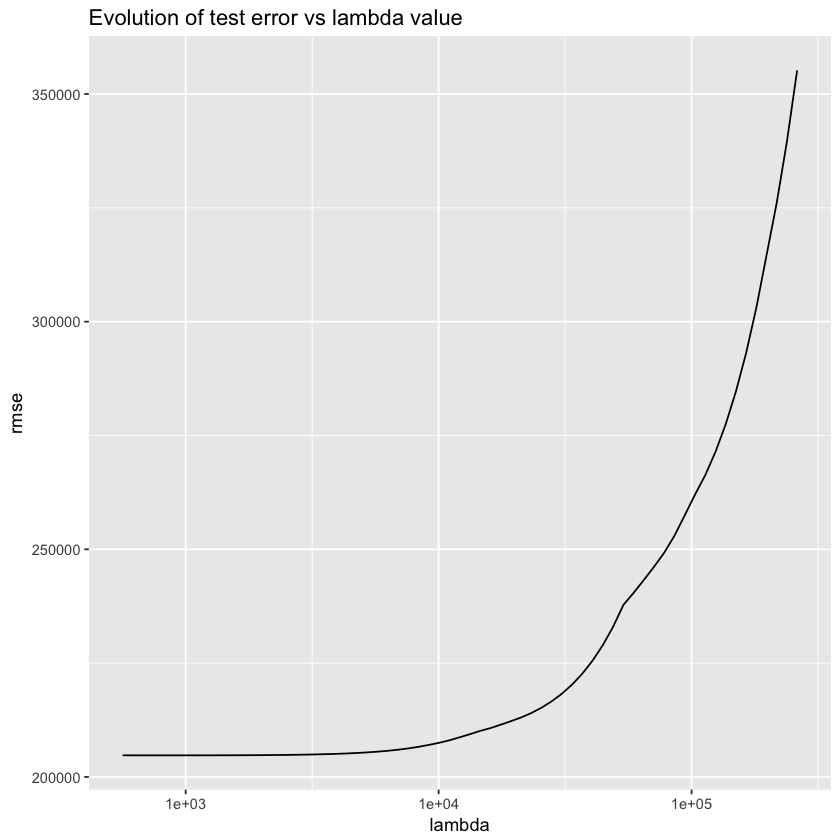

In [5]:
##Different L1 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),
             as.matrix(housingData[indexTrain]$price) , family="gaussian",
             alpha=1)
 
pred_L1_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1=sqrt(apply(pred_L1_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()
require(plotly)
 

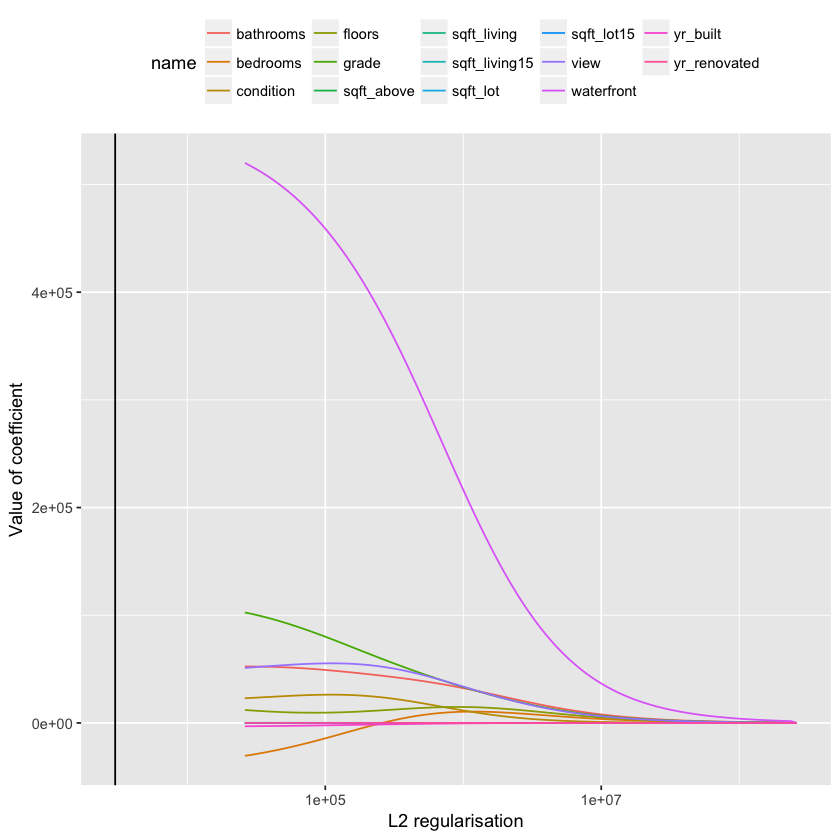

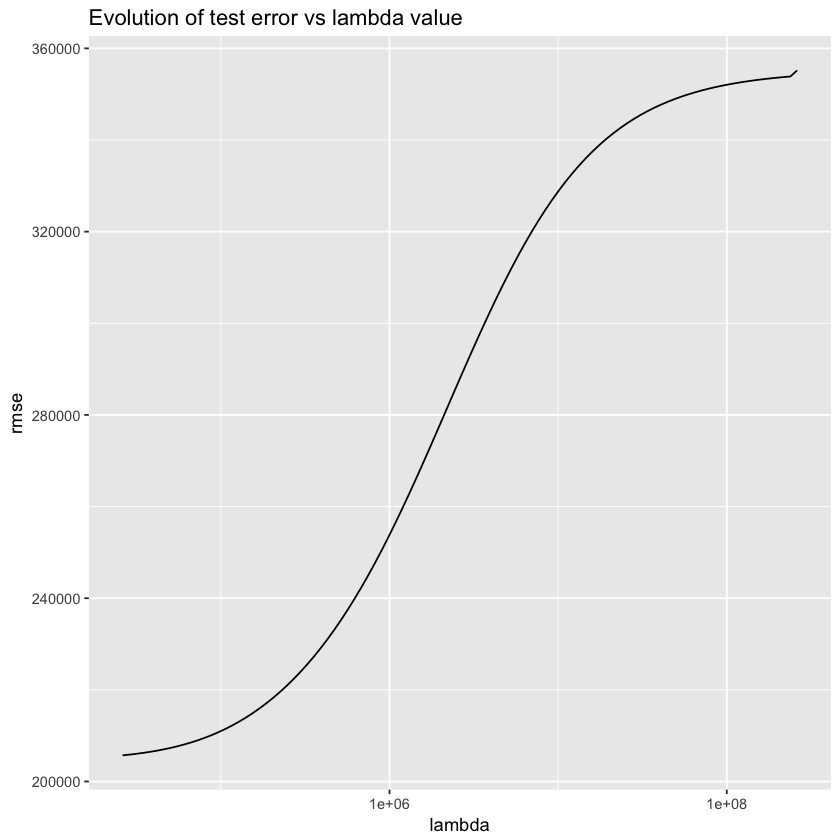

In [6]:
## L2 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=0.0)
 
pred_L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L2=sqrt(apply(pred_L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L2)
plotCoeffEvolution(fit,'L2')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()

 


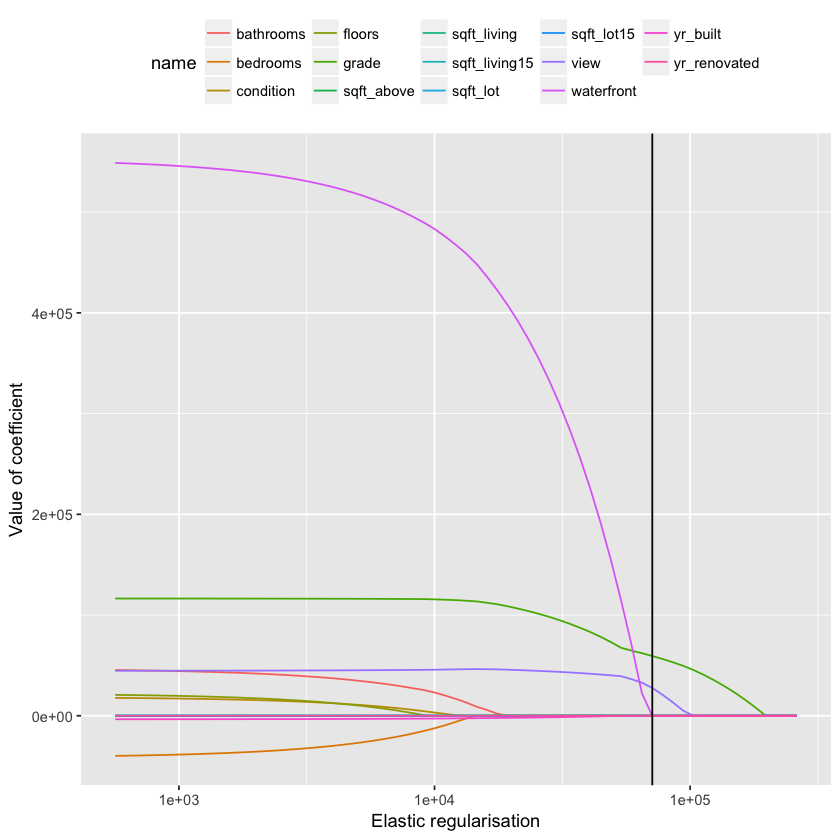

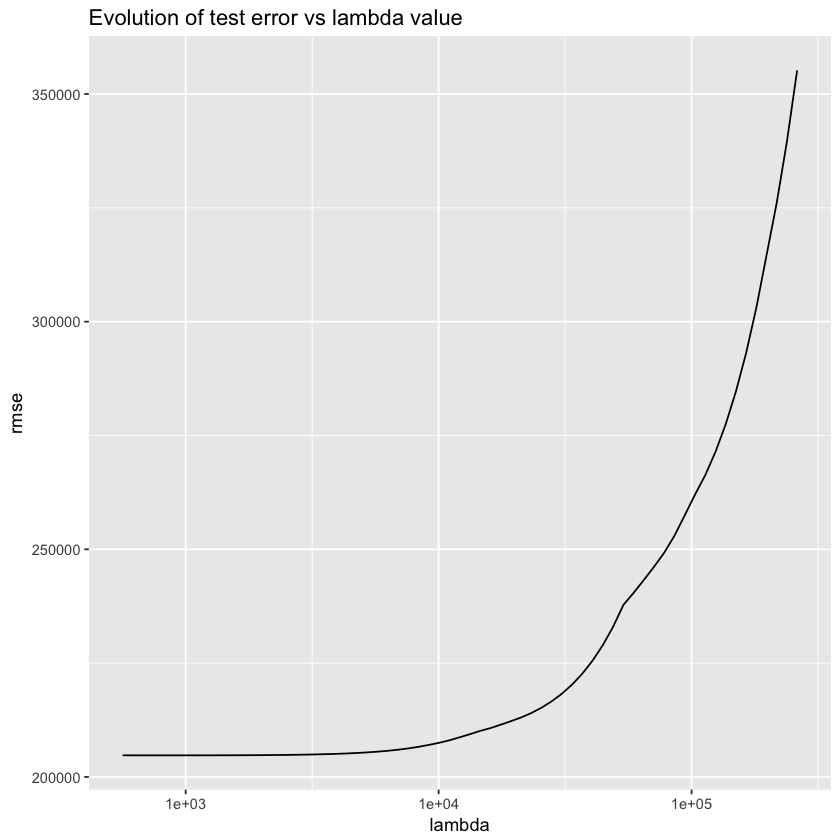

In [110]:
## L1 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=1)
 
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1L2)
plotCoeffEvolution(fit,'Elastic')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()

In [111]:
housingData

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15
221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,1340,5650
538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991,1690,7639
180000,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,2720,8062
604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,0,1360,5000
510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,1800,7503
1225000,4,4.50,5420,101930,1.0,0,0,3,11,3890,2001,0,4760,101930
257500,3,2.25,1715,6819,2.0,0,0,3,7,1715,1995,0,2238,6819
291850,3,1.50,1060,9711,1.0,0,0,3,7,1060,1963,0,1650,9711
229500,3,1.00,1780,7470,1.0,0,0,3,7,1050,1960,0,1780,8113
323000,3,2.50,1890,6560,2.0,0,0,3,7,1890,2003,0,2390,7570


In [112]:
pred<-predict(fit,newx=as.matrix(housingData[,-1]),type='response',s=1E-5)
truth<-as.matrix(housingData[,1])

In [113]:
data<-data.frame(pred,truth)

Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.
Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.


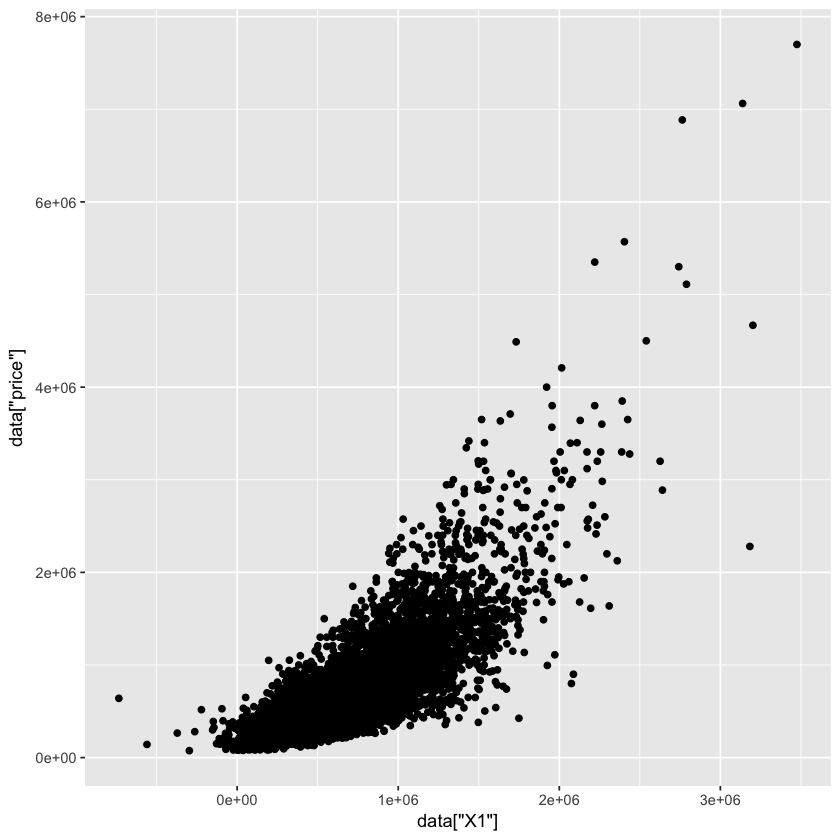

In [114]:
ggplot(data,aes(x=data['X1'],y=data['price']))+geom_point()

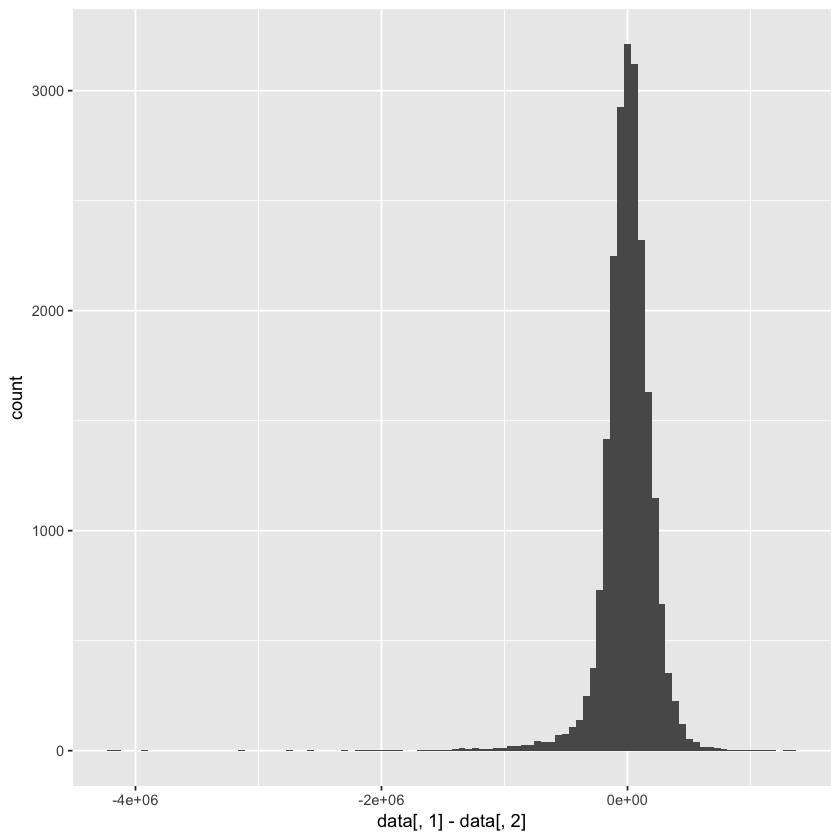

In [115]:
ggplot(data, aes(data[,1]-data[,2])) + geom_histogram(bins=100)


In [116]:
min(RMSE_L1L2)

[1] 204742.5

In [117]:
value=1E12
alpha=0
for (i in 0:100){
var=i/100
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=var)
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
temp<-min(RMSE_L1L2)
if (temp < value){
    value<-temp
    alpha=var}
}

In [118]:
value

[1] 204714.9

In [119]:
alpha

[1] 0.45

In [120]:
vals<-0:100
vals=vals/100


In [121]:
min_loss<-function (var){
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=var)
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
temp<-min(RMSE_L1L2)
    return(temp)
}

In [122]:
loss<-sapply(vals, min_loss)

In [123]:
loss

[1] 205702.5 204739.9 204737.9 204736.9 204735.6 204734.5 204733.2 204732.1
  [9] 204731.0 204729.9 204728.9 204727.8 204726.8 204725.9 204725.0 204724.2
 [17] 204723.4 204722.6 204721.7 204721.2 204720.4 204719.7 204719.2 204718.6
 [25] 204718.3 204717.7 204717.2 204716.9 204716.6 204716.3 204715.9 204715.8
 [33] 204715.5 204715.7 204715.6 204715.4 204715.3 204715.3 204715.2 204715.1
 [41] 204715.1 204714.9 204714.9 204714.9 204715.0 204714.9 204715.0 204715.1
 [49] 204717.2 204715.2 204717.0 204719.4 204719.4 204717.2 204717.1 204717.1
 [57] 204717.0 204716.7 204720.2 204720.3 204720.2 204720.2 204720.5 204720.4
 [65] 204720.6 204723.2 204724.1 204722.9 204723.7 204724.4 204725.1 204725.8
 [73] 204726.5 204727.1 204727.8 204728.4 204729.0 204729.6 204730.2 204730.8
 [81] 204731.3 204731.9 204732.4 204733.0 204733.5 204734.0 204734.4 204734.9
 [89] 204735.3 204735.8 204738.7 204736.6 204737.0 204737.4 204740.4 204740.8
 [97] 204741.1 204741.5 204741.8 204742.2 204742.5

In [124]:
min(loss)

[1] 204714.9

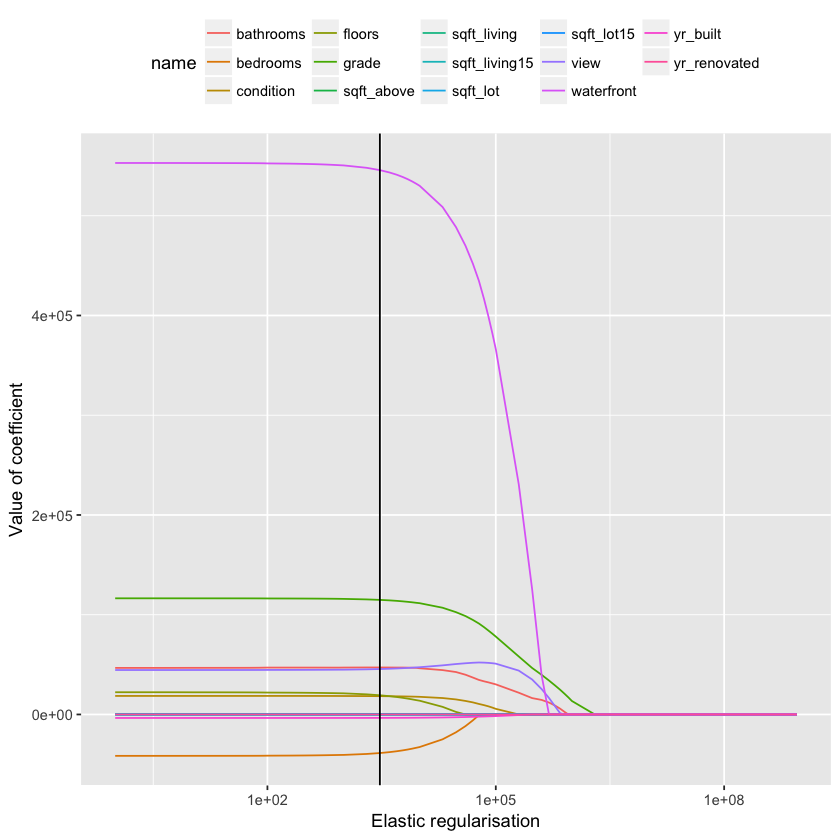

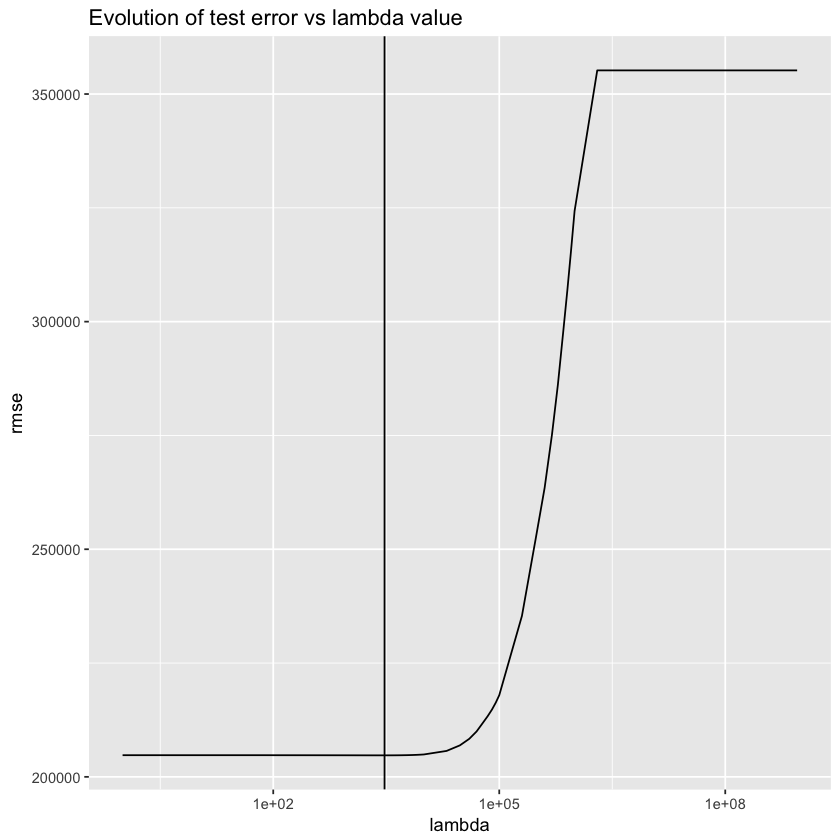

In [129]:
##Different L1L2 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=0.17, lambda=ll)
 
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1L2)
plotCoeffEvolution(fit,'Elastic')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()+ geom_vline(xintercept=3000.95)

In [126]:
DF_plot[DF_plot$rmse==min(DF_plot$rmse),]

,lambda,rmse
s51,3000,204724.5


In [95]:
l1=1:9

In [96]:
l2=l1*10
l3=l1*100
l4=l1*1000
l5=l1*10000
l6=l1*100000
l7=l1*1000000
l8=l1*10000000
l9=l1*100000000

In [104]:
ll=c(l1,l2,l3,l4,l5,l6,l7,l8,l9)

In [103]:
ll

[1]   1   2   3   4   5   6   7   8   9  10  20  30  40  50  60  70  80  90 100
[20] 200 300 400 500 600 700 800 900